# **Air Quality Prediction**

# Importing necessary libraries

In [380]:
# importing the neccessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
import warnings



# Ignore all warnings
warnings.filterwarnings('ignore')

## **Importing Data**

In [381]:
# Paths for Kaggle and GitHub
K_Path = None  # Placeholder for Kaggle path
G_path = "Data/AirQualityUCI.csv"  # GitHub local path

# Check if the Kaggle dataset exists
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if "AirQualityUCI" in filename:  # Match specific dataset name
            K_Path = os.path.join(dirname, filename)  # Correct assignment
            break
    if K_Path:  # Exit the loop if the file is found
        break

# Load the dataset
if K_Path and os.path.exists(K_Path):
    air_data = pd.read_csv(K_Path, sep=";")  # Load Kaggle dataset
    print(f"Dataset loaded from Kaggle: {K_Path}")
elif os.path.exists(G_path):
    air_data = pd.read_csv(G_path, sep=";")  # Fallback to GitHub dataset
    print(f"Dataset loaded from GitHub: {G_path}")
else:
    air_data = None
    print("Failed to load the dataset from both Kaggle and GitHub.")
print("Dataset loaded successfully.")


Dataset loaded from Kaggle: /kaggle/input/airqualityuci/AirQualityUCI.csv
Dataset loaded successfully.


**1.1 Getting to know data**

In [382]:
air_data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


### Dataset Information:

#### Content:

The dataset contains 9357 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located on the field in a significantly polluted area, at road level,within an Italian city. Data were recorded from March 2004 to February 2005 (one year) representing the longest freely available recordings of on field deployed air quality chemical sensor devices responses. Ground Truth hourly averaged concentrations for CO, Non Metanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx) and Nitrogen Dioxide (NO2) and were provided by a co-located reference certified analyzer. Evidences of cross-sensitivities as well as both concept and sensor drifts are present as described in De Vito et al., Sens. And Act. B, Vol. 129,2,2008 (citation required) eventually affecting sensors concentration estimation capabilities.

* Values are separated by `;`
* Missing values are tagged with `-200` value.
* Decimal points are represented by `,`

This dataset can be used exclusively for research purposes. Commercial purposes are fully excluded.

#### Attribute Information:

0: Date (DD/MM/YYYY)

1: Time (HH.MM.SS)

2: True hourly averaged concentration CO in mg/m^3 (reference analyzer)

3: PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)

4: True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer)

5: True hourly averaged Benzene concentration in microg/m^3 (reference analyzer)

6: PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)

7: True hourly averaged NOx concentration in ppb (reference analyzer)

8: PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted)

9: True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)

10: PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)

11: PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted)

12: Temperature in Â°C

13: Relative Humidity (%)

14: AH Absolute Humidity

In [383]:
air_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   object 
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   object 
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   object 
 13  RH             9357 non-null   object 
 14  AH             9357 non-null   object 
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(10), object(7)
memory usage: 1.2+ MB


### 2. Data Cleaning

In [384]:
air_data.isnull().sum()

Date              114
Time              114
CO(GT)            114
PT08.S1(CO)       114
NMHC(GT)          114
C6H6(GT)          114
PT08.S2(NMHC)     114
NOx(GT)           114
PT08.S3(NOx)      114
NO2(GT)           114
PT08.S4(NO2)      114
PT08.S5(O3)       114
T                 114
RH                114
AH                114
Unnamed: 15      9471
Unnamed: 16      9471
dtype: int64

## Dropping the Unnamed: 15, & Unnamed: 16 column since 100% of that are Null values

In [385]:
air_data.drop(['Unnamed: 15','Unnamed: 16'], axis=1, inplace=True)
air_data.isnull().sum()

Date             114
Time             114
CO(GT)           114
PT08.S1(CO)      114
NMHC(GT)         114
C6H6(GT)         114
PT08.S2(NMHC)    114
NOx(GT)          114
PT08.S3(NOx)     114
NO2(GT)          114
PT08.S4(NO2)     114
PT08.S5(O3)      114
T                114
RH               114
AH               114
dtype: int64

In [386]:
air_data.tail(114)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
9357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


By observation, we identify that some rows have completely zero data to work with!!!

Let's Identify the last row index from where the value starts to get null completely

## droping all 114 last rows from 9357 to 9471

In [387]:
air_data.drop(index=[x for x in range(9357, 9471)], axis=1, inplace=True)
air_data.isnull().sum()

Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

## Separating Hour from Time

In [388]:
air_data['Time'].dtype

dtype('O')

In [389]:
air_data['Hour']=air_data['Time'].apply(lambda x: x.split('.')[0])
air_data.Hour.head()

0    18
1    19
2    20
3    21
4    22
Name: Hour, dtype: object

## Setting Date as index

In [390]:
air_data['Date']=pd.to_datetime(air_data.Date, format='%d/%m/%Y')
air_data.set_index('Date',inplace=True)
air_data.head()

,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Hour
Date,,,,,,,,,,,,,,,
2004-03-10,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",18
2004-03-10,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",19
2004-03-10,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",20
2004-03-10,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",21
2004-03-10,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",22


# 3. Visualizing Data Relations
## 3.1 Understand Co-Relation between Attributes

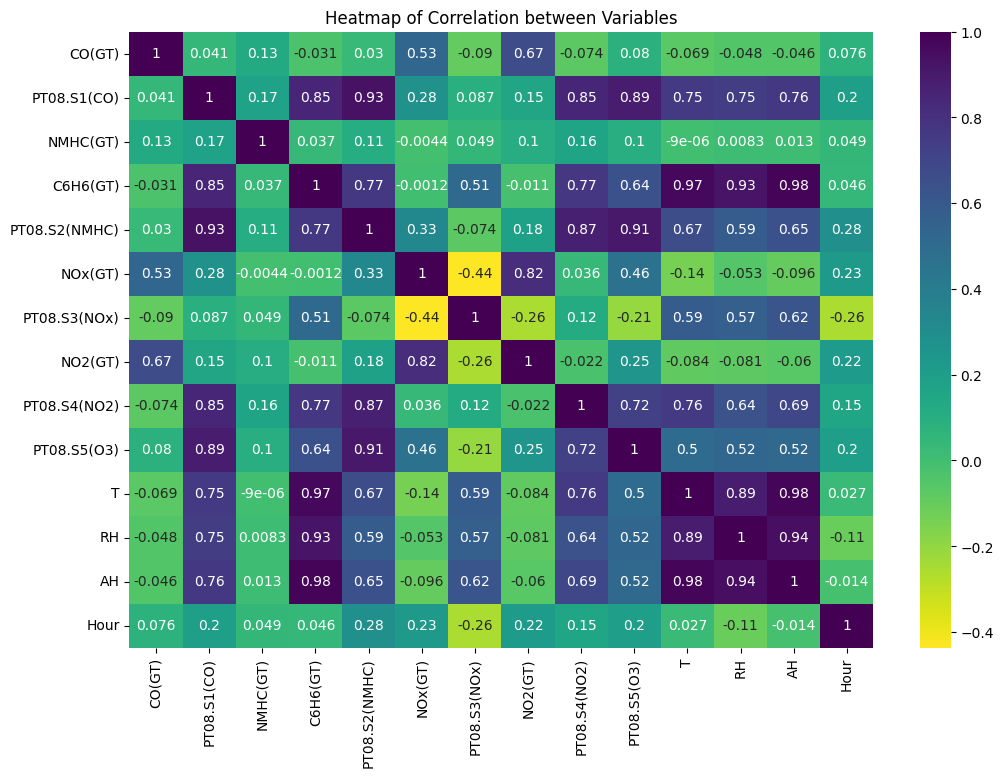

In [391]:
# Step 1: Replace commas with periods (if applicable) and convert to numeric
for column in air_data.columns:
    if air_data[column].dtype == 'object':  # Check if the column is of type object (likely contains strings)
        air_data[column] = air_data[column].str.replace(',', '.', regex=False)  # Replace commas with periods
        air_data[column] = pd.to_numeric(air_data[column], errors='coerce')  # Convert to numeric, invalid parsing will become NaN

# Step 2: Drop non-numeric columns if not needed
air_data_numeric = air_data.drop(columns=['Date', 'Time'], errors='ignore')  # Adjust column names as per your dataset

# Step 3: Handle missing values (optional)
air_data_numeric = air_data_numeric.dropna()  # Drop rows with NaN values (if any remain)

correlation_matrix = air_data_numeric.corr()
# Step 4: Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis_r')
plt.title('Heatmap of Correlation between Variables', fontsize=12)
plt.show()

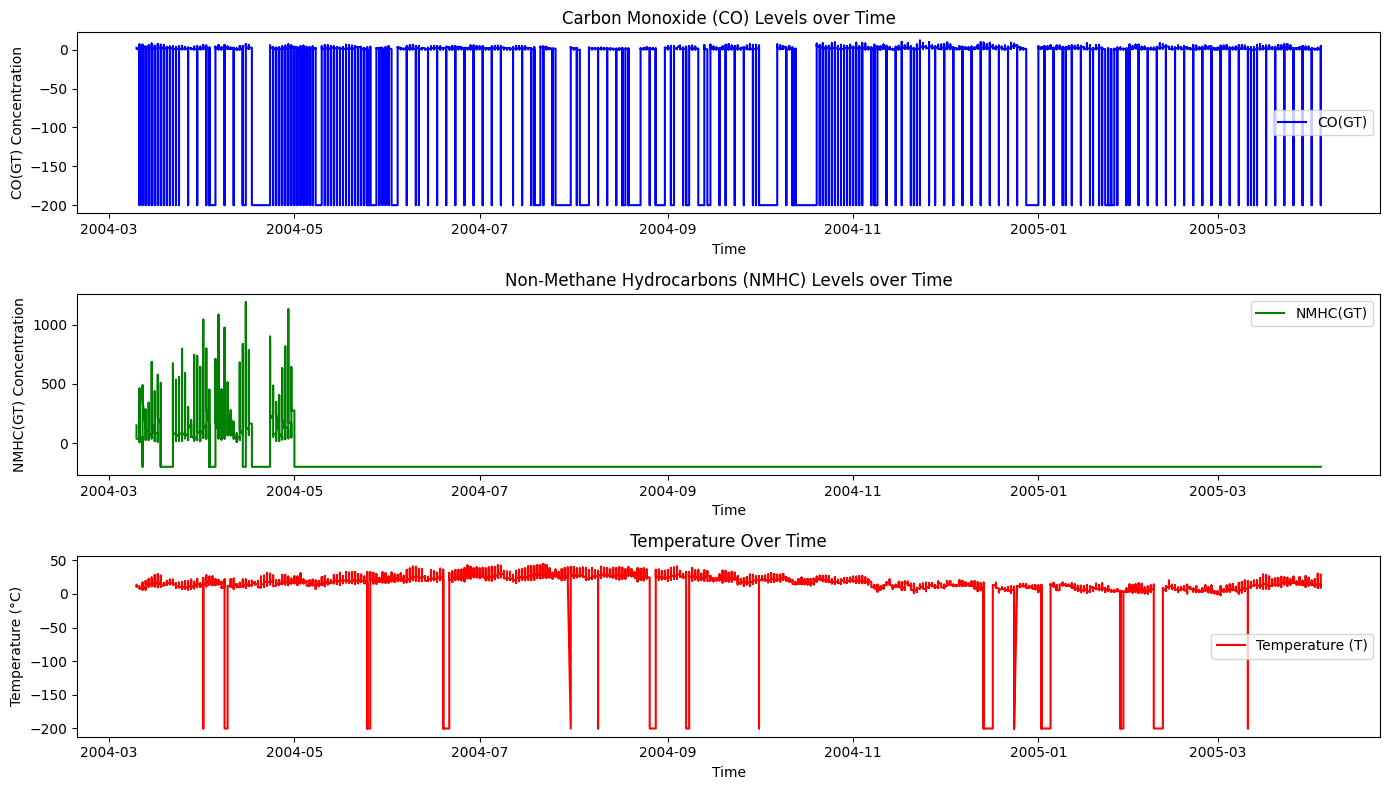

In [393]:
# Plot the trends for selected pollutants and temperature
plt.figure(figsize=(14, 8))

# Plot Carbon Monoxide 'CO(GT)' Levels over Time
plt.subplot(3, 1, 1)
plt.plot(air_data.index, air_data['CO(GT)'], label='CO(GT)', color='b')
plt.xlabel('Time')
plt.ylabel('CO(GT) Concentration')
plt.title('Carbon Monoxide (CO) Levels over Time')
plt.legend()

# Plot Non-Methane Hydrocarbons 'NMHC(GT)' Levels over Time
plt.subplot(3, 1, 2)
plt.plot(air_data.index, air_data['NMHC(GT)'], label='NMHC(GT)', color='g')
plt.xlabel('Time')
plt.ylabel('NMHC(GT) Concentration')
plt.title('Non-Methane Hydrocarbons (NMHC) Levels over Time')
plt.legend()

# Plot Temperature 'T' over time
plt.subplot(3, 1, 3)
plt.plot(air_data.index, air_data['T'], label='Temperature (T)', color='r')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Over Time')
plt.legend()

plt.tight_layout()
plt.show()



# 4. Data Preprocessing

## Normalizing the data

In [395]:

scaler = StandardScaler()
scaled_data = scaler.fit_transform(air_data[['CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)', 'T', 'RH', 'AH']])

## Define Features (X) and Labels (y)

In [ ]:
def create_sequences(data, seq_length=24):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Create sequences for LSTM
X, y = create_sequences(scaled_data, seq_length=24)

## Split the data into Train and Test Sets

In [396]:
# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# 5. Modeling


## **LSTM**

In [397]:
# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=8))  # Number of output features

# Compile the model
model.compile(optimizer=Adam(), loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
# Predict on test data
y_pred = model.predict(X_test)

# Inverse transform the predictions to get the actual scale
y_pred_actual = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y_test)

# Evaluate performance
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test_actual, y_pred_actual)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')


Epoch 1/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.5619 - val_loss: 0.2209
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.2642 - val_loss: 0.1808
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.2056 - val_loss: 0.1605
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.1861 - val_loss: 0.1476
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.1848 - val_loss: 0.1384
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.1752 - val_loss: 0.1331
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.1633 - val_loss: 0.1301
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.1614 - val_loss: 0.1301
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.1575 - val_loss: 0.1338
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.1562 - val_loss: 0.1284
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Mean Squared Error: 2744.632574699246
Mean Absolute Error: 21.440862237559713


## **ARIMA**

In [398]:
# Select the 'CO(GT)' column for ARIMA model
co_data = air_data['CO(GT)'].dropna()

# Split data into train and test
train_data = co_data[:int(len(co_data) * 0.8)]
test_data = co_data[int(len(co_data) * 0.8):]

# Fit ARIMA model (you may need to fine-tune the parameters)
arima_model = ARIMA(train_data, order=(5,1,0))  # p=5, d=1, q=0 (for example)
arima_model_fit = arima_model.fit()

# Make predictions
arima_pred = arima_model_fit.forecast(steps=len(test_data))

# Evaluate ARIMA performance
arima_mse = mean_squared_error(test_data, arima_pred)
arima_mae = mean_absolute_error(test_data, arima_pred)

print(f'ARIMA Mean Squared Error: {arima_mse}')
print(f'ARIMA Mean Absolute Error: {arima_mae}')


ARIMA Mean Squared Error: 1964.7094654341465
ARIMA Mean Absolute Error: 10.912847353821363


## **Actual vs predicted**

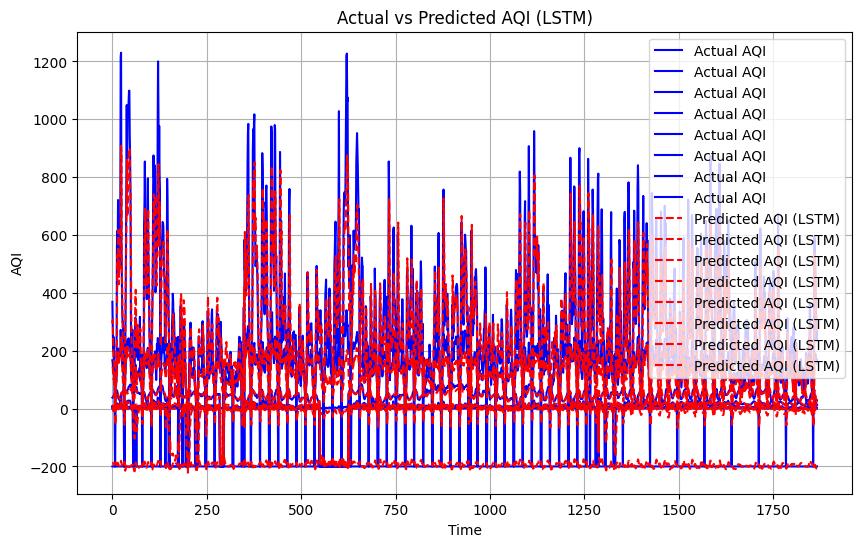

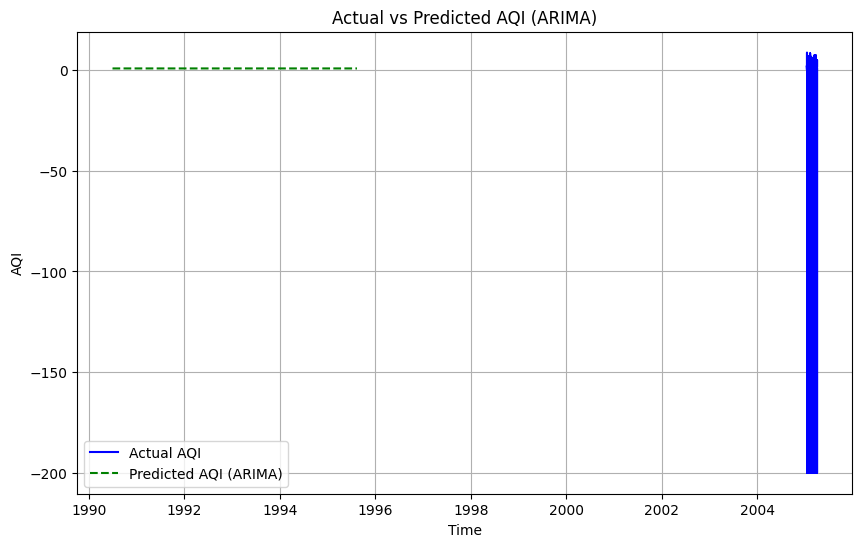

In [406]:
# Plot for LSTM
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual AQI', color='blue')
plt.plot(y_pred_actual, label='Predicted AQI (LSTM)', color='red', linestyle='dashed')
plt.title('Actual vs Predicted AQI (LSTM)')
plt.xlabel('Time')
plt.ylabel('AQI')
plt.legend()
plt.grid(True)
plt.show()

# Plot for ARIMA
plt.figure(figsize=(10, 6))
plt.plot(test_data, label='Actual AQI', color='blue')
plt.plot(arima_pred, label='Predicted AQI (ARIMA)', color='green', linestyle='dashed')
plt.title('Actual vs Predicted AQI (ARIMA)')
plt.xlabel('Time')
plt.ylabel('AQI')
plt.legend()
plt.grid(True)
plt.show()

## **Model Comparision**

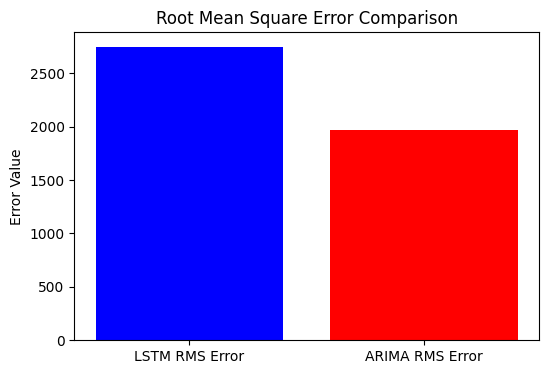

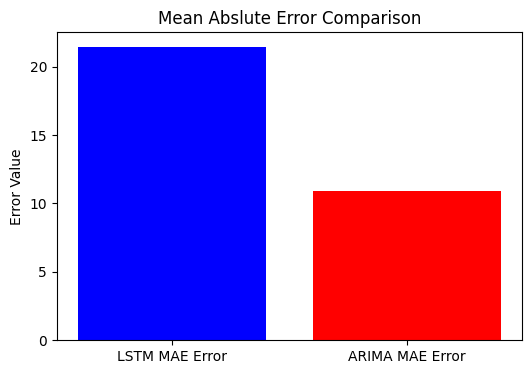

In [405]:
plt.figure(figsize=(6, 4))
plt.bar(['LSTM RMS Error', 'ARIMA RMS Error'], [mse, arima_mse], color=['blue', 'red'])
plt.title('Root Mean Square Error Comparison')
plt.ylabel('Error Value')
plt.show()

# Bar plot for MAE error comparison
plt.figure(figsize=(6, 4))
plt.bar(['LSTM MAE Error', 'ARIMA MAE Error'], [mae, arima_mae], color=['blue', 'red'])
plt.title('Mean Abslute Error Comparison')
plt.ylabel('Error Value')
plt.show()

## Conclusion:

Based on the **Actual vs. Predicted AQI** plots and the **Mean Squared Error (MSE)** and **Mean Absolute Error (MAE)** results for both models, we can draw the following insights:

### LSTM Model:
- The LSTM model, while capable of capturing complex patterns over time, exhibits significant variance between actual and predicted AQI values, especially in the higher ranges of AQI.
- **MSE**: 2744.63, which is considerably higher than that of the ARIMA model, indicating that LSTM has larger errors (squared differences) overall.
- **MAE**: 21.44, showing that the LSTM's predictions are, on average, off by approximately 21 AQI units.

### ARIMA Model:
- The ARIMA model, on the other hand, demonstrates a more consistent prediction, as indicated by the smoother line in the **Actual vs. Predicted AQI** plot.
- **MSE**: 1964.71, which is smaller than the LSTM's MSE, indicating that the ARIMA model has fewer large errors, making it a more accurate model in terms of squared error.
- **MAE**: 10.91, showing that the ARIMA model's predictions, on average, are off by approximately 11 AQI units, which is lower than the LSTM model's MAE.

## Recommendation:

- **ARIMA Model** is recommended for this dataset, as it shows **lower error metrics (MSE and MAE)** than the LSTM model. The smaller MSE suggests that ARIMA is able to model the AQI trend more accurately, with fewer outlier errors, making it a more robust and reliable choice for forecasting air quality in this case.
- While LSTM models excel in capturing sequential patterns in more complex datasets, in this particular case, **ARIMA's performance** is more favorable. This could be due to the relatively simpler nature of the AQI data, where ARIMA's time-series forecasting approach is more effective.
  
Therefore, **ARIMA** should be the preferred model for **predicting AQI** in this scenario, especially when the goal is to minimize prediction errors in terms of both squared and absolute errors. However, if the dataset becomes more complex or includes additional features, revisiting the LSTM model might be worth exploring.
